In [6]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import os
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# NLTK 리소스 다운로드 (불용어 사용)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/juhwan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Read Data  
데이터 불러오기

In [7]:
# Cell 2: Load datasets

# 현재 작업 디렉토리 설정
current_dir = os.getcwd()

# 도서 데이터 로드
books_data_path = os.path.join(current_dir, 'books_with_genres.csv')
books_data = pd.read_csv(books_data_path)

# 영화 데이터 로드
movies_data_path = os.path.join(current_dir, "movie.csv")
movies_data = pd.read_csv(movies_data_path)

# 평점 데이터 로드
ratings_data_path = os.path.join(current_dir, 'rating.csv')
ratings = pd.read_csv(ratings_data_path)

# 데이터 확인
print("Books Data:")
display(books_data.head())

print("\nMovies Data:")
display(movies_data.head())

print("\nRatings Data:")
display(ratings.head())

Books Data:


,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,genre
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,"Young Adult, Fiction, Fantasy, Science Fiction..."
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,"Young Adult, Magic, Childrens, Middle Grade, A..."
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,"Fantasy, Young Adult, Romance, Fiction, Vampir..."
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,"Fiction, Historical Fiction, School, Literatur..."
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,"Fiction, School, Historical Fiction, Romance, ..."



Movies Data:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



Ratings Data:


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


## PreProcessing  
데이터 전처리

In [8]:
# Cell 3: Data Preprocessing

# 결측치 처리
books_data.dropna(inplace=True)
movies_data.dropna(inplace=True)
ratings.dropna(inplace=True)

# 전처리 함수: 영화 텍스트 결합 및 불용어 제거
def preprocess_text(title, genres):
    if pd.isna(genres) or genres is None:
        genres = ""
    text = f"{title} {genres}".lower()
    text = text.replace('|', ' ')
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# 전처리 함수: 도서 텍스트 결합 및 불용어 제거
def preprocess_book_text(title, authors, genres):
    if pd.isna(genres) or genres is None:
        genres = ""
    if pd.isna(authors) or authors is None:
        authors = ""
    genres = genres.replace(',', ' ').replace('  ', ' ')
    text = f"{title} {authors} {genres}".lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# 'content' 열 생성
movies_data['content'] = movies_data.apply(lambda row: preprocess_text(row['title'], row['genres']), axis=1)
books_data['content'] = books_data.apply(lambda row: preprocess_book_text(row['title'], row['authors'], row['genre']), axis=1)

# 데이터 확인
print("Preprocessed Movies Data:")
display(movies_data[['movieId', 'title', 'genres', 'content']].head())

print("\nPreprocessed Books Data:")
display(books_data[['book_id', 'title', 'authors', 'genre', 'content']].head())


Preprocessed Movies Data:


,movieId,title,genres,content
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,toy story adventure animation children comedy ...
1,2,Jumanji (1995),Adventure|Children|Fantasy,jumanji adventure children fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,grumpier old men comedy romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,waiting exhale comedy drama romance
4,5,Father of the Bride Part II (1995),Comedy,father bride part ii comedy



Preprocessed Books Data:


,book_id,title,authors,genre,content
0,2767052,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,"Young Adult, Fiction, Fantasy, Science Fiction...",hunger games hunger games suzanne collins youn...
1,3,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré","Young Adult, Magic, Childrens, Middle Grade, A...",harry potter sorcerers stone harry potter jk r...
2,41865,"Twilight (Twilight, #1)",Stephenie Meyer,"Fantasy, Young Adult, Romance, Fiction, Vampir...",twilight twilight stephenie meyer fantasy youn...
3,2657,To Kill a Mockingbird,Harper Lee,"Fiction, Historical Fiction, School, Literatur...",kill mockingbird harper lee fiction historical...
4,4671,The Great Gatsby,F. Scott Fitzgerald,"Fiction, School, Historical Fiction, Romance, ...",great gatsby f scott fitzgerald fiction school...


## Visualization  
데이터 시각화

Books Data Statistics:
       average_rating  ratings_count
count     7643.000000   7.643000e+03
mean         3.994778   6.111598e+04
std          0.251234   1.746704e+05
min          2.470000   3.427000e+03
25%          3.840000   1.429550e+04
50%          4.010000   2.286300e+04
75%          4.170000   4.630050e+04
max          4.820000   4.780653e+06

Movies Data Statistics:
       average_rating  ratings_count
count    26744.000000   26744.000000
mean         3.133200     747.841123
std          0.664084    3085.818268
min          0.500000       1.000000
25%          2.800000       3.000000
50%          3.235294      18.000000
75%          3.565217     205.000000
max          5.000000   67310.000000


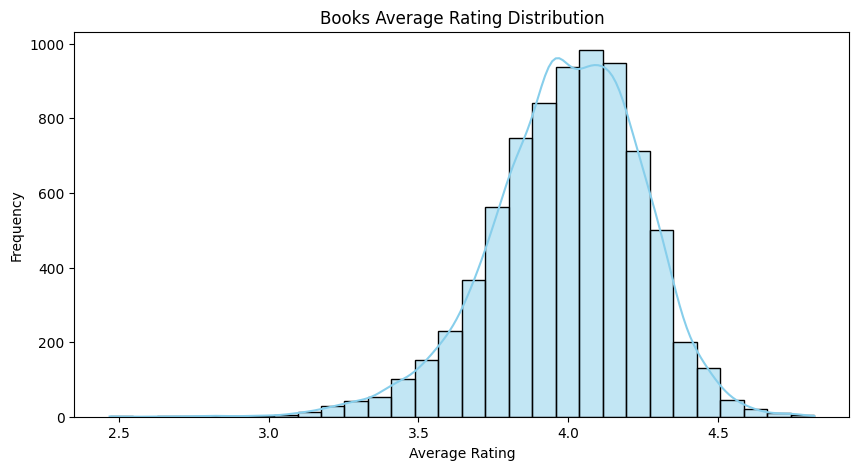

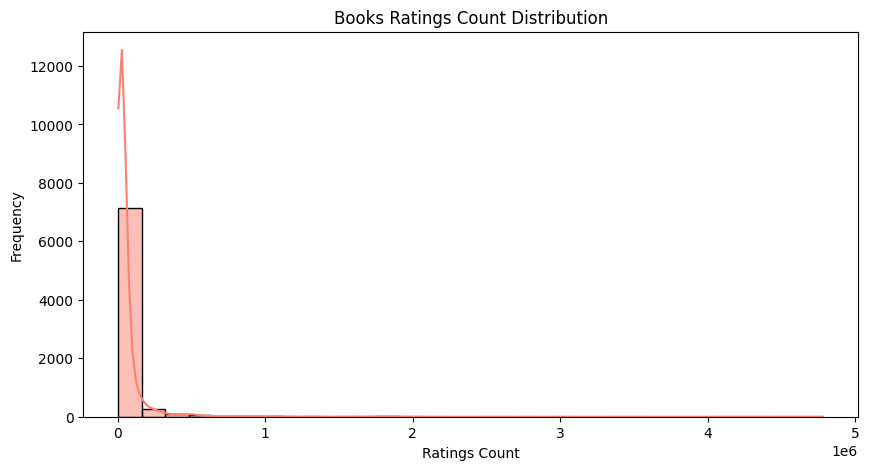

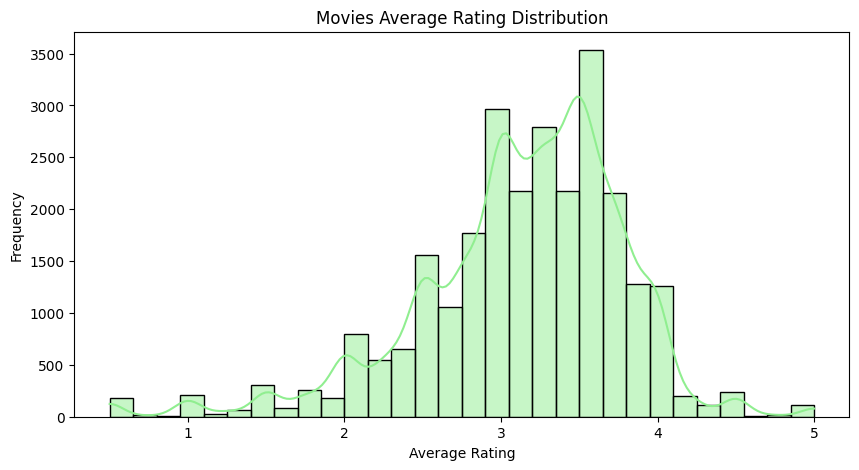

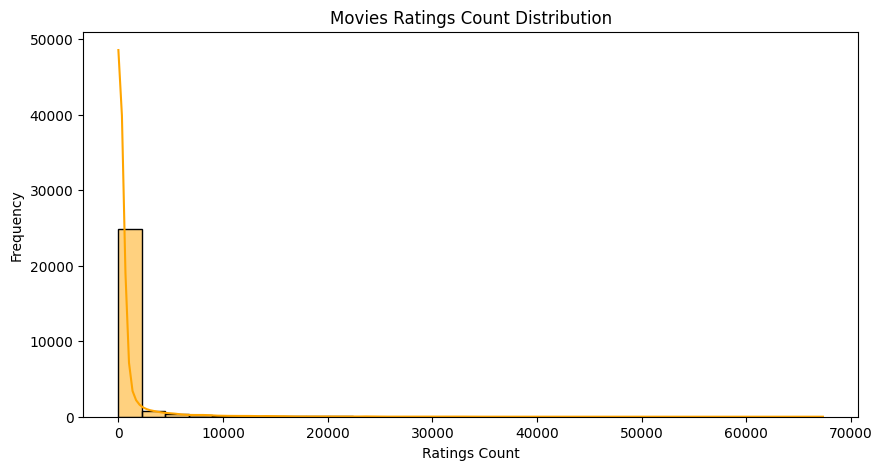

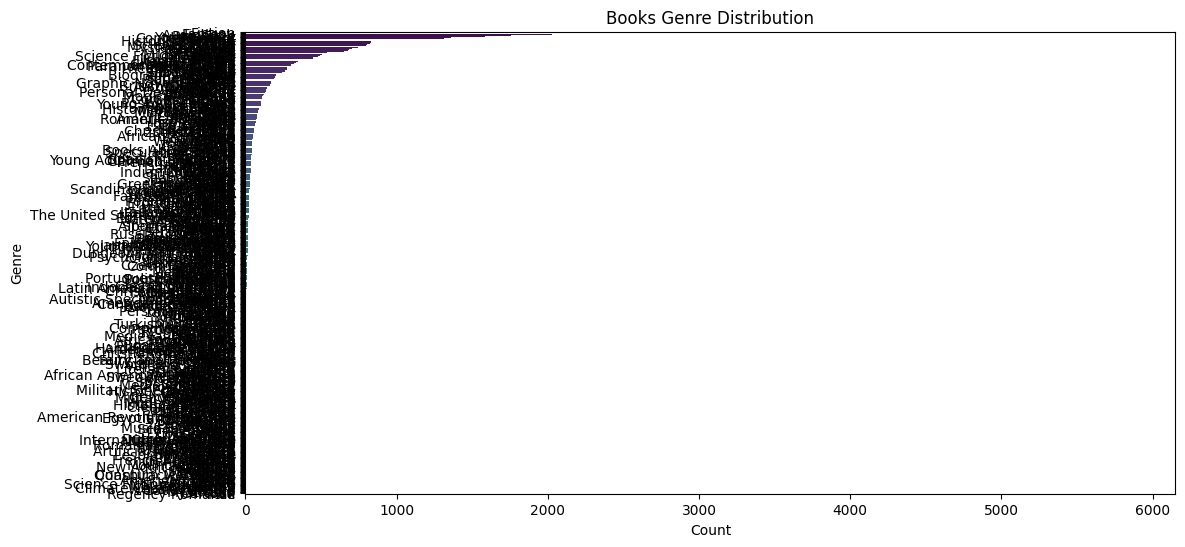

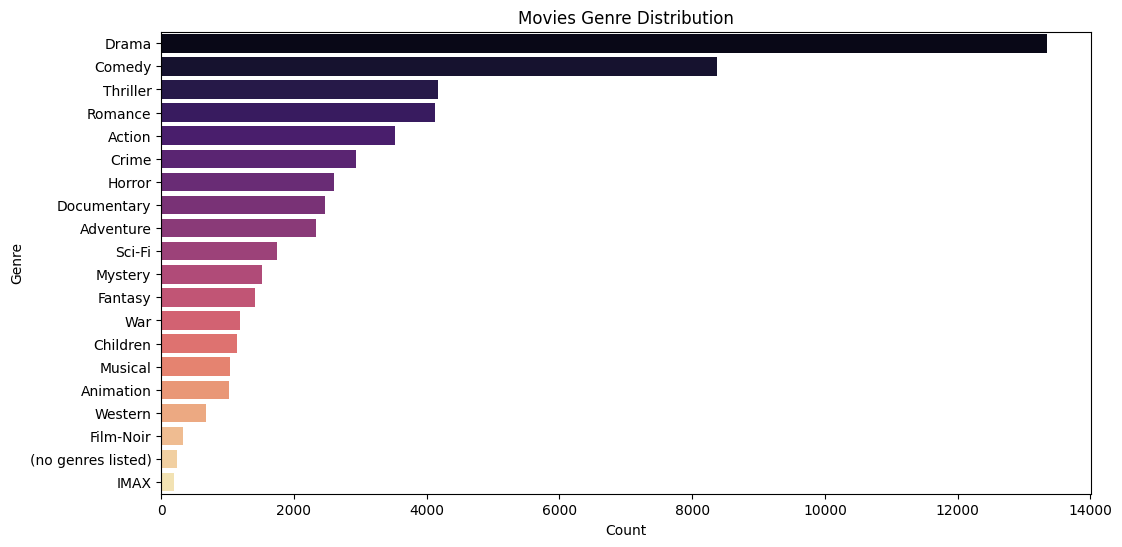

In [9]:
# Cell 4: Basic Statistics and Visualization

def basic_statistics_and_visualization(books_data, movies_data, ratings):
    # 도서 데이터 통계
    print("Books Data Statistics:")
    print(books_data[['average_rating', 'ratings_count']].describe())
    
    # 영화 데이터 통계
    # 영화에 대한 평균 평점과 평점 수 계산
    movie_ratings = ratings.groupby('movieId').agg({'rating': ['mean', 'count']})
    movie_ratings.columns = ['average_rating', 'ratings_count']
    movie_ratings.reset_index(inplace=True)
    
    # 영화 데이터와 병합
    movies_with_ratings = movies_data.merge(movie_ratings, on='movieId', how='left')
    print("\nMovies Data Statistics:")
    print(movies_with_ratings[['average_rating', 'ratings_count']].describe())
    
    # 시각화
    plt.figure(figsize=(10, 5))
    sns.histplot(books_data['average_rating'], bins=30, kde=True, color='skyblue')
    plt.title('Books Average Rating Distribution')
    plt.xlabel('Average Rating')
    plt.ylabel('Frequency')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.histplot(books_data['ratings_count'], bins=30, kde=True, color='salmon')
    plt.title('Books Ratings Count Distribution')
    plt.xlabel('Ratings Count')
    plt.ylabel('Frequency')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.histplot(movies_with_ratings['average_rating'].dropna(), bins=30, kde=True, color='lightgreen')
    plt.title('Movies Average Rating Distribution')
    plt.xlabel('Average Rating')
    plt.ylabel('Frequency')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.histplot(movies_with_ratings['ratings_count'].dropna(), bins=30, kde=True, color='orange')
    plt.title('Movies Ratings Count Distribution')
    plt.xlabel('Ratings Count')
    plt.ylabel('Frequency')
    plt.show()
    
    # 도서 장르 분포 시각화
    plt.figure(figsize=(12, 6))
    books_genres = books_data['genre'].str.split(', ').explode()
    sns.countplot(y=books_genres, order=books_genres.value_counts().index, palette='viridis')
    plt.title('Books Genre Distribution')
    plt.xlabel('Count')
    plt.ylabel('Genre')
    plt.show()
    
    # 영화 장르 분포 시각화
    plt.figure(figsize=(12, 6))
    movies_genres = movies_data['genres'].str.split('|').explode()
    sns.countplot(y=movies_genres, order=movies_genres.value_counts().index, palette='magma')
    plt.title('Movies Genre Distribution')
    plt.xlabel('Count')
    plt.ylabel('Genre')
    plt.show()

# 기본 통계량 및 시각화 실행
basic_statistics_and_visualization(books_data, movies_data, ratings)

## user-item matrix & SVD  
사용자-아이템 매트릭스 생성 및 svd적용

In [10]:
# Cell 5: Create User-Item Matrix and Apply SVD

# 사용자-영화 매트릭스 생성
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
print("User-Item Matrix Shape:", user_item_matrix.shape)

# SVD 적용을 위한 매트릭스 분해
svd = TruncatedSVD(n_components=50, random_state=42)
latent_matrix = svd.fit_transform(user_item_matrix)

# SVD 컴포넌트 확인
print("Latent Matrix Shape:", latent_matrix.shape)

# SVD의 설명된 분산 비율 확인
explained_variance = svd.explained_variance_ratio_.sum()
print(f"Total Explained Variance by SVD: {explained_variance:.2f}")

User-Item Matrix Shape: (138493, 26744)
Latent Matrix Shape: (138493, 50)
Total Explained Variance by SVD: 0.37


### recommendation function implement
추천함수 구현

In [35]:
# Cell 6: Define Movie Recommendation Function

# 영화 ID와 인덱스 매핑 생성
movie_id_to_index = {movie_id: idx for idx, movie_id in enumerate(user_item_matrix.columns)}
index_to_movie_id = {idx: movie_id for movie_id, idx in movie_id_to_index.items()}

# 사용자-아이템 매트릭스 재구성
reconstructed_matrix = np.dot(latent_matrix, svd.components_)

def recommend_movies(user_id, movies_data, user_item_matrix, reconstructed_matrix, movie_id_to_index, index_to_movie_id, num_recommendations=10):
    if user_id not in user_item_matrix.index:
        print(f"User ID {user_id} not found.")
        return
    
    # 사용자 인덱스 찾기
    user_index = user_item_matrix.index.get_loc(user_id)
    
    # 사용자에 대한 재구성된 평점
    user_predicted_ratings = reconstructed_matrix[user_index]
    
    # 상위 N개의 영화 인덱스 추출
    recommended_indices = np.argsort(user_predicted_ratings)[::-1][:num_recommendations]
    
    # 영화 ID로 변환
    recommended_movie_ids = [index_to_movie_id[idx] for idx in recommended_indices]
    
    # 추천 영화 데이터 추출
    recommended_movies = movies_data[movies_data['movieId'].isin(recommended_movie_ids)].copy()
    recommended_movies['predicted_rating'] = user_predicted_ratings[recommended_indices]
    
    # 평점 기준으로 정렬
    recommended_movies.sort_values(by='predicted_rating', ascending=False, inplace=True)
    
    return recommended_movies

# 사용자에게 추천된 영화 출력
user_id = 1
recommended_movies = recommend_movies(user_id, movies_data, user_item_matrix, reconstructed_matrix, movie_id_to_index, index_to_movie_id, 10)
print(f"Top 10 Recommended Movies for User {user_id}:")
display(recommended_movies[['movieId', 'title', 'predicted_rating']])

Top 10 Recommended Movies for User 1:


,movieId,title,predicted_rating
49,50,"Usual Suspects, The (1995)",5.107457
1113,1136,Monty Python and the Holy Grail (1975),4.976336
1173,1198,Raiders of the Lost Ark (Indiana Jones and the...,4.964388
1175,1200,Aliens (1986),4.813581
1188,1214,Alien (1979),4.730580
1230,1258,"Shining, The (1980)",4.559297
1263,1291,Indiana Jones and the Last Crusade (1989),4.285350
4897,4993,"Lord of the Rings: The Fellowship of the Ring,...",4.135628
5853,5952,"Lord of the Rings: The Two Towers, The (2002)",3.796471
7041,7153,"Lord of the Rings: The Return of the King, The...",3.776341


In [50]:
# Cell 7: Evaluate Recommendations using Actual Ratings

def evaluate_recommendations(user_id, recommended_movies, ratings):
    # 사용자에 대한 실제 평점 데이터 필터링
    actual_ratings = ratings[(ratings['userId'] == user_id) & (ratings['movieId'].isin(recommended_movies['movieId']))]
    
    if actual_ratings.empty:
        print("No actual ratings available for evaluation.")
        return 0
    
    # 예측 평점과 실제 평점 추출
    try:
        predicted_ratings = recommended_movies.set_index('movieId').loc[actual_ratings['movieId']]['predicted_rating'].values
        actual_ratings = actual_ratings.set_index('movieId').loc[recommended_movies['movieId']].reset_index()['rating'].values
        
        # MAE 및 RMSE 계산
        mae = mean_absolute_error(actual_ratings, predicted_ratings)
        rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
        
        print(f"\nEvaluation Metrics for User {user_id}:")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    except:
        print("Error occurred during evaluation.")

# 평가 지표 계산
evaluate_recommendations(user_id, recommended_movies, ratings)


Evaluation Metrics for User 3:
Mean Absolute Error (MAE): 0.6525
Root Mean Squared Error (RMSE): 0.8329


In [51]:
for i in range(1, 10):    
    user_id = i
    recommended_movies = recommend_movies(user_id, movies_data, user_item_matrix, reconstructed_matrix, movie_id_to_index, index_to_movie_id, 10)
    #print(f"Top 10 Recommended Movies for User {user_id}:")
    #display(recommended_movies[['movieId', 'title', 'predicted_rating']])
    evaluate_recommendations(user_id, recommended_movies, ratings)


Evaluation Metrics for User 1:
Mean Absolute Error (MAE): 0.9729
Root Mean Squared Error (RMSE): 1.0391
Error occurred during evaluation.

Evaluation Metrics for User 3:
Mean Absolute Error (MAE): 0.6525
Root Mean Squared Error (RMSE): 0.8329
Error occurred during evaluation.
Error occurred during evaluation.

Evaluation Metrics for User 6:
Mean Absolute Error (MAE): 1.4313
Root Mean Squared Error (RMSE): 1.6083

Evaluation Metrics for User 7:
Mean Absolute Error (MAE): 0.6326
Root Mean Squared Error (RMSE): 0.7447

Evaluation Metrics for User 8:
Mean Absolute Error (MAE): 0.6789
Root Mean Squared Error (RMSE): 0.7534
Error occurred during evaluation.


## 도서 추천 함수 정의 및 실행

In [20]:
# Cell 8: Define and Execute Book Recommendation Function

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
movie_tfidf = vectorizer.fit_transform(movies_data['content'])
book_tfidf = vectorizer.transform(books_data['content'].fillna(''))

# 코사인 유사도 계산
cosine_sim = cosine_similarity(movie_tfidf, book_tfidf)

def recommend_books_for_movie_by_name(movie_name, movies_data, books_data, cosine_sim, num_recommendations=5):
    movie_indices = movies_data[movies_data['title'].str.contains(movie_name, case=False, na=False)].index
    
    if len(movie_indices) == 0:
        return f"Cannot find the movie '{movie_name}'."
    
    movie_idx = movie_indices[0]  # 첫 번째 검색된 영화만 사용
    
    # 해당 영화와 모든 책들에 대한 유사도
    sim_scores = list(enumerate(cosine_sim[movie_idx]))
    
    # 유사도 높은 책들을 내림차순으로 정렬
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # 가장 유사한 책들의 인덱스 추출
    book_indices = [x[0] for x in sim_scores[:num_recommendations]]
    
    # 추천된 책들 반환
    return books_data['title'].iloc[book_indices]

# 책 추천 예시
movie_name = "World of Apu"
print(f"\nBooks similar to the movie '{movie_name}':")
recommended_books = recommend_books_for_movie_by_name(movie_name, movies_data, books_data, cosine_sim, 10)
print(recommended_books)



Books similar to the movie 'World of Apu':
1804               Night World, No. 3 (Night World, #7-9)
1080         Winter of the World (The Century Trilogy #2)
3674      Genghis Khan and the Making of the Modern World
143     Unbroken: A World War II Story of Survival, Re...
2049               Night World, No. 2 (Night World, #4-6)
9242                        A Little History of the World
8120      1493: Uncovering the New World Columbus Created
808           Brave New World / Brave New World Revisited
4970    No Ordinary Time: Franklin and Eleanor Rooseve...
3681    Lost in Shangri-la: A True Story of Survival, ...
Name: title, dtype: object
